# Análisis de Kernel PCA
Kernel PCA es una extensión no lineal del Análisis de Componentes Principales (PCA). Mientras que en este último solo captura relaciones lineales, Kernel PCA permite capturar patrones no lineales aplicando la idea del **kernel trick**.

In [1]:
## Implementación
### Librería de scikit learn
from sklearn.decomposition import KernelPCA

In [2]:
## Bases de datos
import pandas as pd
import glob
archivos = glob.glob("*.csv")
lista = []
for f in archivos:
    df = pd.read_csv(f)

    ## Extraer info desde el nombre del archivo
    anio = f[:4]
    region = f.split("_")[2]

    df["Año"] = anio
    df["Región"] = region

    lista.append(df)
## Unir todo
data = pd.concat(lista, ignore_index = True)
data.head()


,Fecha y hora,CO (ppm),NO (ppb),NO2 (ppb),O3 (ppb),SR (kW/m2),Año,Región
0,2024-01-01 00:00:00,8.25,158.8,50.9,18.0,0.000,2024,Sureste2
1,2024-01-01 06:00:00,3.17,65.8,33.3,15.2,0.000,2024,Sureste2
2,2024-01-01 12:00:00,1.14,12.4,12.0,33.6,0.177,2024,Sureste2
3,2024-01-01 18:00:00,1.06,4.9,7.1,39.0,0.015,2024,Sureste2
4,2024-01-02 00:00:00,1.09,5.9,9.4,31.0,0.000,2024,Sureste2


In [3]:
## Nos aseguramos de que no hayan valores nulos
data.isnull().sum()

,0
Fecha y hora,0
CO (ppm),0
NO (ppb),0
NO2 (ppb),0
O3 (ppb),0
SR (kW/m2),0
Año,0
Región,0


In [4]:
## Selección de variables
variables = ["CO (ppm)", "NO (ppb)", "NO2 (ppb)", "O3 (ppb)", "SR (kW/m2)"]
X = data[variables]

In [5]:
## Se escalan los datos
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [6]:
## Se aplica Kernel PCA
kpca = KernelPCA(n_components = 2,
                 kernel = "rbf",
                 gamma=0.1)

X_kpca = kpca.fit_transform(X_scaled)

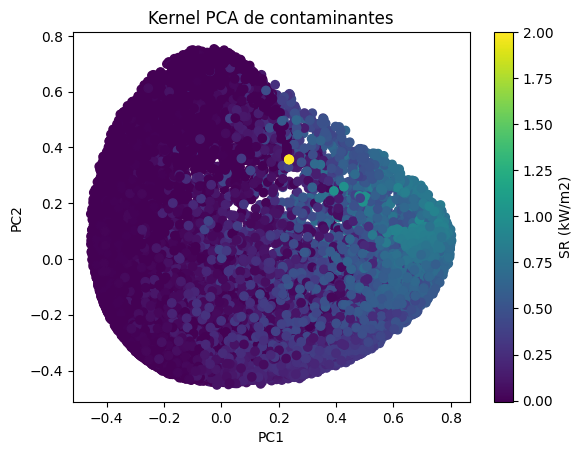

In [7]:
## Graficar losd resultados
import matplotlib.pyplot as plt
plt.scatter(X_kpca[:,0], X_kpca[:,1], c =  data["SR (kW/m2)"].astype(float))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Kernel PCA de contaminantes")
plt.colorbar(label = "SR (kW/m2)")
plt.show()

In [15]:
## Aproximaciones a la componentes
contaminantes = ["CO (ppm)", "NO (ppb)", "NO2 (ppb)", "O3 (ppb)"]
pcs = pd.DataFrame(X_kpca, columns=['PC1','PC2'])
corrs = pcs.join(data[variables]).corr()
corrs['PC1']

,PC1
PC1,1.000000e+00
PC2,-1.494808e-16
CO (ppm),3.783238e-02
NO (ppb),3.076995e-02
NO2 (ppb),-9.394973e-02
O3 (ppb),7.616821e-01
SR (kW/m2),8.481119e-01


In [17]:
contaminantes = ["CO (ppm)", "NO (ppb)", "NO2 (ppb)", "O3 (ppb)"]
pcs = pd.DataFrame(X_kpca, columns=['PC1','PC2'])
corrs = pcs.join(data[variables]).corr()
corrs['PC2']

,PC2
PC1,-1.494808e-16
PC2,1.000000e+00
CO (ppm),6.791631e-01
NO (ppb),3.630109e-01
NO2 (ppb),6.821056e-01
O3 (ppb),-2.864857e-01
SR (kW/m2),-1.936987e-02


In [14]:
## Kernel PCA con eigenvalues habilitados
import numpy as np
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=0.1,
    eigen_solver="arpack",
    remove_zero_eig=True
)

var_pc1 = np.var(X_kpca[:,0])
var_pc2 = np.var(X_kpca[:,1])

suma = var_pc1 + var_pc2

print("Varianza explicada aproximada:")
print("PC1:", var_pc1 / suma)
print("PC2:", var_pc2 / suma)

Varianza explicada aproximada:
PC1: 0.5825959671374062
PC2: 0.41740403286259375


In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([
    ('kpca', KernelPCA(kernel='rbf', fit_inverse_transform=False)),
    ('svc', SVC())
])

param_dist = {
    'kpca__gamma': uniform(0.0001, 2),
    'kpca__n_components': randint(2, 6),   # de 2 a 6 componentes
    'svc__C': uniform(0.1, 100),
    'svc__gamma': uniform(0.001, 1)
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
y = (data["O3 (ppb)"] > data["O3 (ppb)"].median()).astype(int)

random_search.fit(X_scaled, y)

print("\nMEJORES HIPERPARÁMETROS:")
print(random_search.best_params_)

print("\nMEJOR SCORE:")
print(random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits

MEJORES HIPERPARÁMETROS:
{'kpca__gamma': np.float64(0.11292315805420051), 'kpca__n_components': 5, 'svc__C': np.float64(83.34426408004217), 'svc__gamma': np.float64(0.21333911067827616)}

MEJOR SCORE:
0.9861188029570377


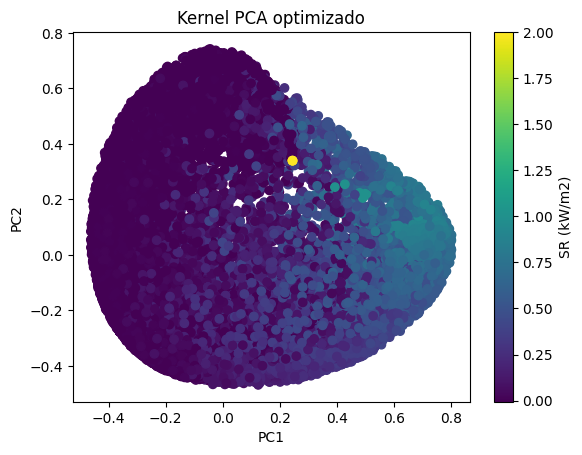

In [ ]:
best_kpca = random_search.best_estimator_.named_steps["kpca"]
X_kpca = best_kpca.fit_transform(X_scaled)

plt.scatter(X_kpca[:,0], X_kpca[:,1], c=data["SR (kW/m2)"].astype(float))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Kernel PCA optimizado")
plt.colorbar(label="SR (kW/m2)")
plt.show()

In [ ]:
pcs = pd.DataFrame(X_kpca[:, :2], columns=["PC1", "PC2"])
corrs = pcs.join(data[variables]).corr()
print("\nCORRELACIONES DE PC1:")
print(corrs["PC1"])


CORRELACIONES DE PC1:
PC1           1.000000e+00
PC2          -1.871953e-16
CO (ppm)      6.590640e-02
NO (ppb)      5.029106e-02
NO2 (ppb)    -6.019471e-02
O3 (ppb)      7.424272e-01
SR (kW/m2)    8.405450e-01
Name: PC1, dtype: float64


## Conclusión
En este análisis se reveló que la mayor parte de la variabilidad conjunta entre los contaminantes y la radiación solar se organiza alrededor de un eje principal (PC1). Este eje está fuertemente asociadpo a la radiación solar (SR (kW/m2) y al Ozono ($O_3$)), mientras que no hay muestra relación con el resto de contaminantes. Se concluye que la radiación solar está estrechamente relacionada vinculada con la formación de ozono. La componente principal 1 captura un fenómeno fotoquímico, a altos valores de SR, altos valores de $O_3$. Esto hace coherencia tanto con lo que se conoce de química atmosfética, como con los otros análisis estadísticos. Esto se ve del gráfico, la componente dominante es la 1, en dirección horizontal, en la cual influyen las variables del ozono y de la radiación.